In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from xgcm.autogenerate import generate_grid_ds
from cmocean import cm
import xscale as xsc

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster( walltime='6:00:00')
w = cluster.scale(5*14)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [14]:
client

Client Scheduler: tcp://10.148.0.36:55984 Dashboard: http://10.148.0.36:8787/status,Cluster Workers: 70 Cores: 70 Memory: 1.20 TB


__________
## Section 1: LLC4320 output
## Section 2: The coarse-graining method, a spatial filter (8, 20, 50 km)
## Section 3: The coarse-graining method, a temporal filter (1, 5, 30 days)
## Section 4: Comparison

_________
# 1. Read LLC4320 output


In [5]:
out_dir_work = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/'

grid = xr.open_dataset(out_dir_work+'Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_work+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_work+'V_total_rechunk.zarr')
ds = xr.merge([ds_U,ds_V,grid])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates: (12/21)
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 ... -14.42 -14.4 -14.38
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.94 49.96 49.97 49.98
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
    ...       ...
    dxG      (lat_g, lon) float32 ...
    dyG      (lat, lon_g) float32 ...
    rA       (lat, lon) float32 ...
    rAz      (lat_g, lon_g) float32 ...
    rAw      (lat, lon_g) float32 ...
    rAs      (lat_g, lon) float32 ...
Data variables:
    U        (time, depth, lat, lon_g) float32 dask.array<chunksize=(9415, 1, 1, 177), meta=np.ndarray>
    V        (time, depth, lat_g, lon) float

In [6]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'}}, periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   lon --> left
  * left     lon_g --> center
Y Axis (periodic, boundary=None):
  * center   lat --> left
  * left     lat_g --> center


________
# 2. Calculate $\Pi_\omega$ using the Coarse-graining method (using a spatial filter)

## KE flux $\Pi_\omega$ at 8-km, 20-km and 50-km 

In [7]:
grid_num = 4  # 4*2km = 8km
grid_num = 10 # 10*2km = 20km
grid_num = 25 # 25*2km = 50km

In [8]:
wt_U = ds['U'].window
wt_U.set(n={'lat': grid_num, 'lon_g': grid_num}, window={'lat':'hanning', 'lon_g':'hanning'}, chunks = {'lat':1, 'lon_g':177,'time': 9415, 'depth':1})
ds_U_filter = wt_U.convolve()

In [9]:
wt_V = ds['V'].window
wt_V.set(n={'lat_g': grid_num, 'lon': grid_num}, window={'lat_g':'hanning', 'lon':'hanning'}, chunks = {'lat_g':1, 'lon':177,'time': 9415, 'depth':1})
ds_V_filter = wt_V.convolve()

In [10]:
wt_U2 = (ds['U']**2).window
wt_U2.set(n={'lat': grid_num, 'lon_g': grid_num}, window={'lat':'hanning', 'lon_g':'hanning'}, chunks = {'lat':1, 'lon_g':177,'time': 9415, 'depth':1})
ds_U2_filter = wt_U2.convolve()

In [11]:
wt_V2 = (ds['V']**2).window
wt_V2.set(n={'lat_g': grid_num, 'lon': grid_num}, window={'lat_g':'hanning', 'lon':'hanning'}, chunks = {'lat_g':1, 'lon':177,'time': 9415, 'depth':1})
ds_V2_filter = wt_V2.convolve()

In [12]:
uv = gridx.interp(ds.V,'Y')*gridx.interp(ds.U,'X')
wt_UV = uv.window
wt_UV.set(n={'lat': grid_num, 'lon': grid_num}, window={'lat':'hanning', 'lon':'hanning'}, chunks = {'lat':1, 'lon':177,'time': 9415, 'depth':1})
ds_UV_filter = wt_UV.convolve()

In [13]:
# f stands for low-pass filter
du_dx = gridx.diff(ds_U_filter, 'X')/gridx.interp(ds.dxG, 'Y')
dv_dy = gridx.diff(ds_V_filter, 'Y')/gridx.interp(ds.dyG, 'X')
du_dy = gridx.interp(gridx.interp(gridx.diff(ds_U_filter, 'Y')/gridx.interp(ds.dyC, 'X'), 'X'), 'Y')
dv_dx = gridx.interp(gridx.interp(gridx.diff(ds_V_filter, 'X')/gridx.interp(ds.dxC, 'Y'), 'X'), 'Y')

PI_1 = (gridx.interp(ds_U2_filter, 'X')-gridx.interp(ds_U_filter**2, 'X'))*du_dx  # [f(u^2) - f(u)^2]*f(du/dx)
PI_2 = (gridx.interp(ds_V2_filter, 'Y')-gridx.interp(ds_V_filter**2, 'Y'))*dv_dy  # [f(v^2) - f(v)^2]*f(dv/dy)
PI_3 = (ds_UV_filter - gridx.interp(ds_U_filter,'X')*gridx.interp(ds_V_filter,'Y') )*(du_dy+dv_dx) # [f(uv) - f(u)f(v)]*[f(du/dy) + f(dv/dx)]

PI_cg = -(PI_1+PI_2+PI_3)
PI_cg

,Array,Chunk
Bytes,69.67 GB,26.36 MB
Shape,"(9415, 52, 201, 177)","(9415, 1, 4, 175)"
Count,1686278 Tasks,18720 Chunks
Type,float32,numpy.ndarray


In [15]:
out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/'
depth_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]

In [16]:
# 1 hour for 20 km (1 min per depth)
# 2.5 hours for 50 km (3 mins per depth)

VV = ['PI_cg_8km']
VV = ['PI_cg_20km']
VV = ['PI_cg_50km']

for depth in depth_all:
    
    for vv in VV:
        
        PI_cg_single = PI_cg.isel(depth=depth)
        chunks = {'lat': 1, 'lon': 177, 'time':9415}            
        PI_cg_single = PI_cg_single.chunk(chunks)
        PI_cg_single = np.real(PI_cg_single).rename('PI_cg_single')     
        PI_cg_single = PI_cg_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        PI_cg_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed
depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed
depth=6 - allready processed
depth=7 - allready processed
depth=8 - allready processed
depth=9 - allready processed
depth=10 - allready processed
depth=11 - allready processed
depth=12 - allready processed
depth=13 - allready processed
depth=14 - allready processed
depth=15 - allready processed
depth=16 - allready processed
depth=17 - allready processed
depth=18 - allready processed
depth=19 - allready processed
depth=20 - allready processed
depth=21 - allready processed
depth=22 - allready processed
depth=23 - allready processed
depth=24 - allready processed
depth=25 - allready processed
depth=26 - allready processed
depth=27 - allready processed
depth=28 - allready processed
depth=29 - allready processed
depth=30 - allready processed
depth=31 - allready processed
depth=32 - allready processed
depth=33 - allready 

# 2.1 KE flux $\Pi_\omega$ at 8-km scale

In [20]:
out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/'
D = [xr.open_zarr(out_dir_store+'PI_cg_8km_d%02d.zarr'%(depth)) for depth in range(51)]
PI_cg = xr.concat(D, dim='depth')

out_dir = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/'
ds_MLD = xr.open_zarr(out_dir+'mld_filter.zarr')

def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime
time_day = iters_to_date(np.arange(9415))
PI_cg = PI_cg.assign_coords(time=time_day) 
ds_MLD = xr.open_zarr(out_dir+'mld_filter.zarr')
ds_MLD = ds_MLD.assign_coords(time=time_day) 

print(PI_cg)

<xarray.Dataset>
Dimensions:       (depth: 51, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth         (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6
  * lat           (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon           (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
  * time          (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
Data variables:
    PI_cg_single  (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 1, 177), meta=np.ndarray>


Text(0.5, 1.0, 'spring')

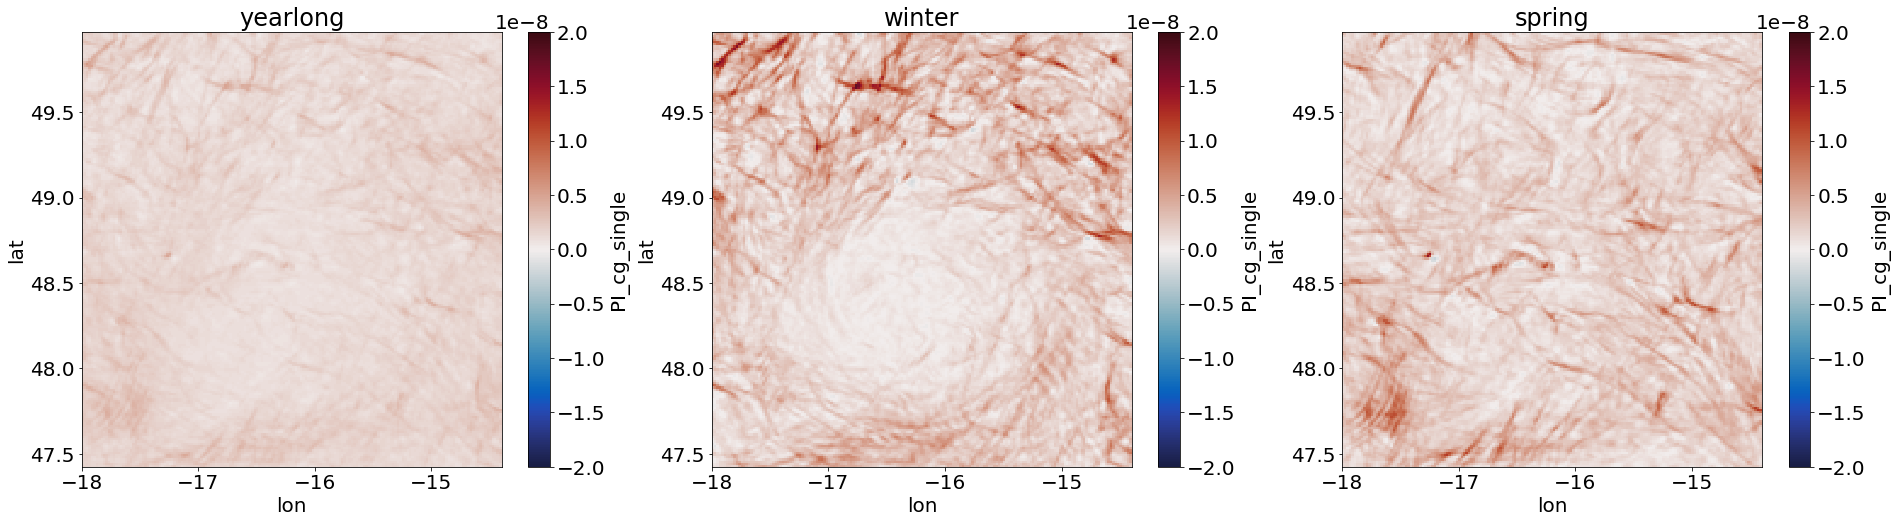

In [21]:
fig, ax = plt.subplots(figsize=(32,8))
# yearlong
ax = plt.subplot(131)
PI_cg.PI_cg_single.isel(lat=slice(2,-2),lon=slice(2,-2)).mean(['time','depth']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-2e-8,vmax=2e-8, add_colorbar = True)
ax.set_title('yearlong')
# winter
ax = plt.subplot(132)
PI_cg.PI_cg_single.isel(lat=slice(2,-2),lon=slice(2,-2)).sel(time=slice('2011-12-01T00:00:00','2012-03-01T00:00:00')).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-2e-8,vmax=2e-8, add_colorbar = True)
ax.set_title('winter')
# spring
ax = plt.subplot(133)
PI_cg.PI_cg_single.isel(lat=slice(2,-2),lon=slice(2,-2)).sel(time=slice('2012-03-01T00:00:00','2012-06-01T00:00:00')).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-2e-8,vmax=2e-8, add_colorbar = True)
ax.set_title('spring')


[Text(15218.0, 0, 'Sep'),
 Text(15248.0, 0, 'Oct'),
 Text(15279.0, 0, 'Nov'),
 Text(15309.0, 0, 'Dec'),
 Text(15340.0, 0, 'Jan (2012)'),
 Text(15371.0, 0, 'Feb'),
 Text(15400.0, 0, 'Mar'),
 Text(15431.0, 0, 'Apr'),
 Text(15461.0, 0, 'May'),
 Text(15492.0, 0, 'Jun'),
 Text(15522.0, 0, 'Jul'),
 Text(15553.0, 0, 'Aug'),
 Text(15584.0, 0, 'Sep')]

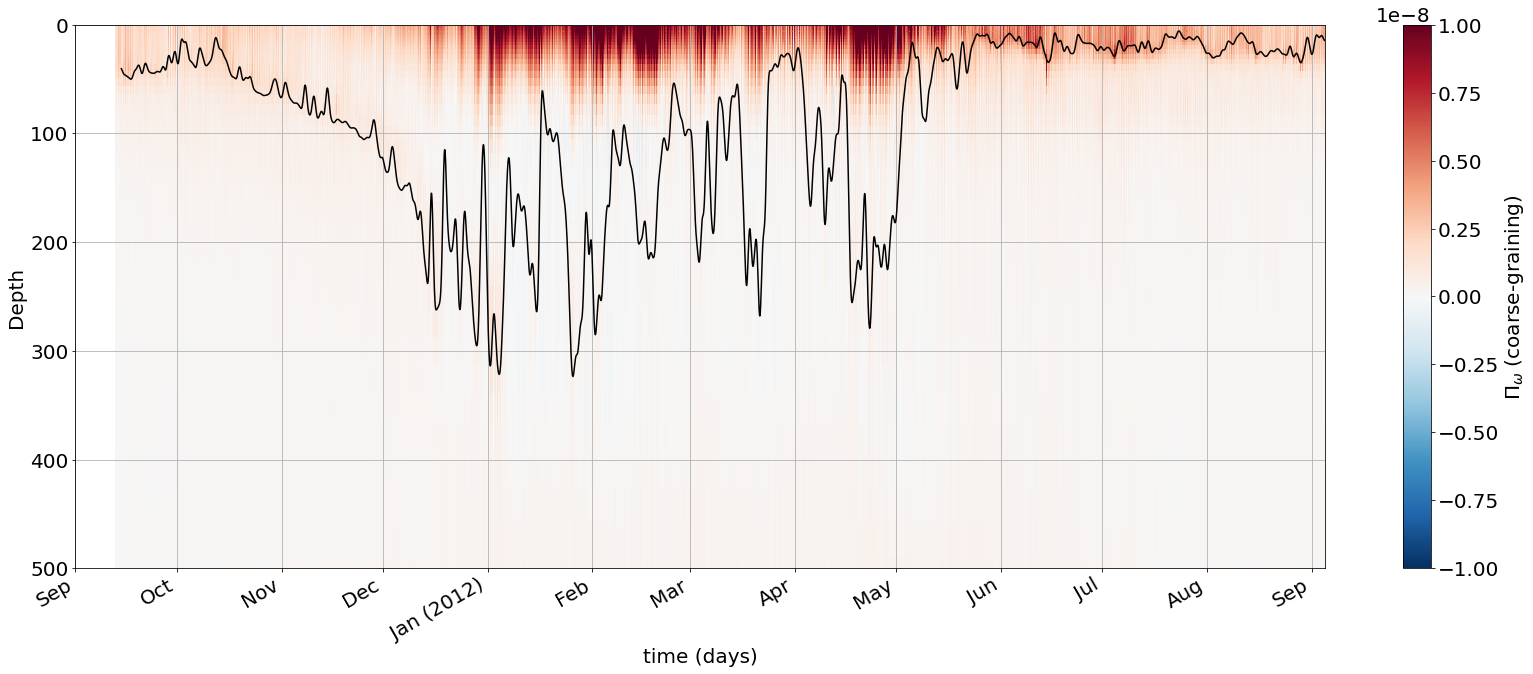

In [43]:
Pi_cg_smean = PI_cg.PI_cg_single.isel(lat=slice(4,-4),lon=slice(4,-4)).mean(['lon','lat'])

plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(28,10))

ax = plt.subplot(111)
cax = Pi_cg_smean.plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.grid()
ax.set_ylim([500., 0.])
ax.set_yticks([500,400,300,200,100,0.])
ds_MLD.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('time (days)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlim(['2011-09', '2012-09-05'])
ax.set_xticks(['2011-09','2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09'])
ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan (2012)', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])

# 2.2 KE flux $\Pi_\omega$ at 20-km scale

In [17]:
out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/'
D = [xr.open_zarr(out_dir_store+'PI_cg_20km_d%02d.zarr'%(depth)) for depth in range(51)]
PI_cg = xr.concat(D, dim='depth')

out_dir = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/'
ds_MLD = xr.open_zarr(out_dir+'mld_filter.zarr')

def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime
time_day = iters_to_date(np.arange(9415))
PI_cg = PI_cg.assign_coords(time=time_day) 
ds_MLD = xr.open_zarr(out_dir+'mld_filter.zarr')
ds_MLD = ds_MLD.assign_coords(time=time_day) 

print(PI_cg)

<xarray.Dataset>
Dimensions:       (depth: 51, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth         (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6
  * lat           (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon           (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
  * time          (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
Data variables:
    PI_cg_single  (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 1, 177), meta=np.ndarray>


Text(0.5, 1.0, 'spring')

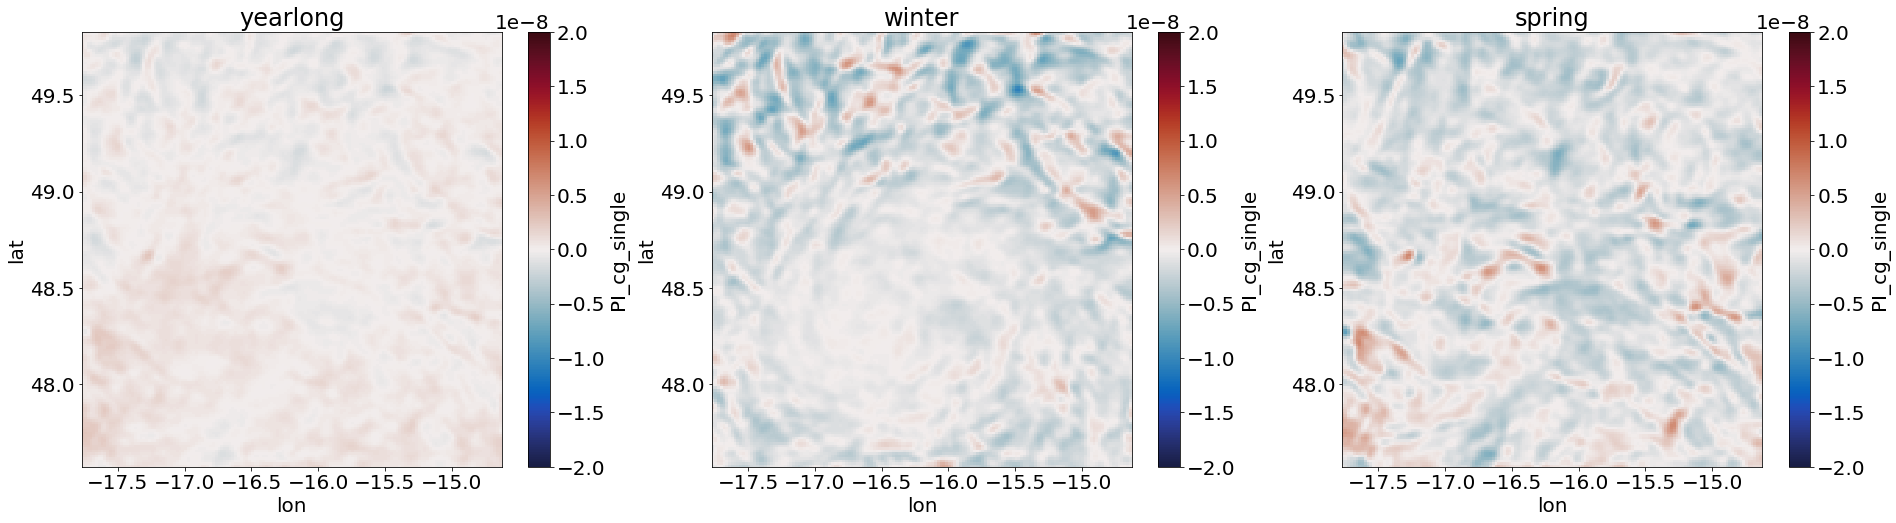

In [21]:
plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(32,8))
# yearlong
ax = plt.subplot(131)
PI_cg.PI_cg_single.isel(lat=slice(13,-13),lon=slice(13,-13)).mean(['time','depth']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-2e-8,vmax=2e-8, add_colorbar = True)
ax.set_title('yearlong')
# winter
ax = plt.subplot(132)
PI_cg.PI_cg_single.isel(lat=slice(13,-13),lon=slice(13,-13)).sel(time=slice('2011-12-01T00:00:00','2012-03-01T00:00:00')).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-2e-8,vmax=2e-8, add_colorbar = True)
ax.set_title('winter')
# spring
ax = plt.subplot(133)
PI_cg.PI_cg_single.isel(lat=slice(13,-13),lon=slice(13,-13)).sel(time=slice('2012-03-01T00:00:00','2012-06-01T00:00:00')).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-2e-8,vmax=2e-8, add_colorbar = True)
ax.set_title('spring')


[Text(15218.0, 0, 'Sep'),
 Text(15248.0, 0, 'Oct'),
 Text(15279.0, 0, 'Nov'),
 Text(15309.0, 0, 'Dec'),
 Text(15340.0, 0, 'Jan (2012)'),
 Text(15371.0, 0, 'Feb'),
 Text(15400.0, 0, 'Mar'),
 Text(15431.0, 0, 'Apr'),
 Text(15461.0, 0, 'May'),
 Text(15492.0, 0, 'Jun'),
 Text(15522.0, 0, 'Jul'),
 Text(15553.0, 0, 'Aug'),
 Text(15584.0, 0, 'Sep')]

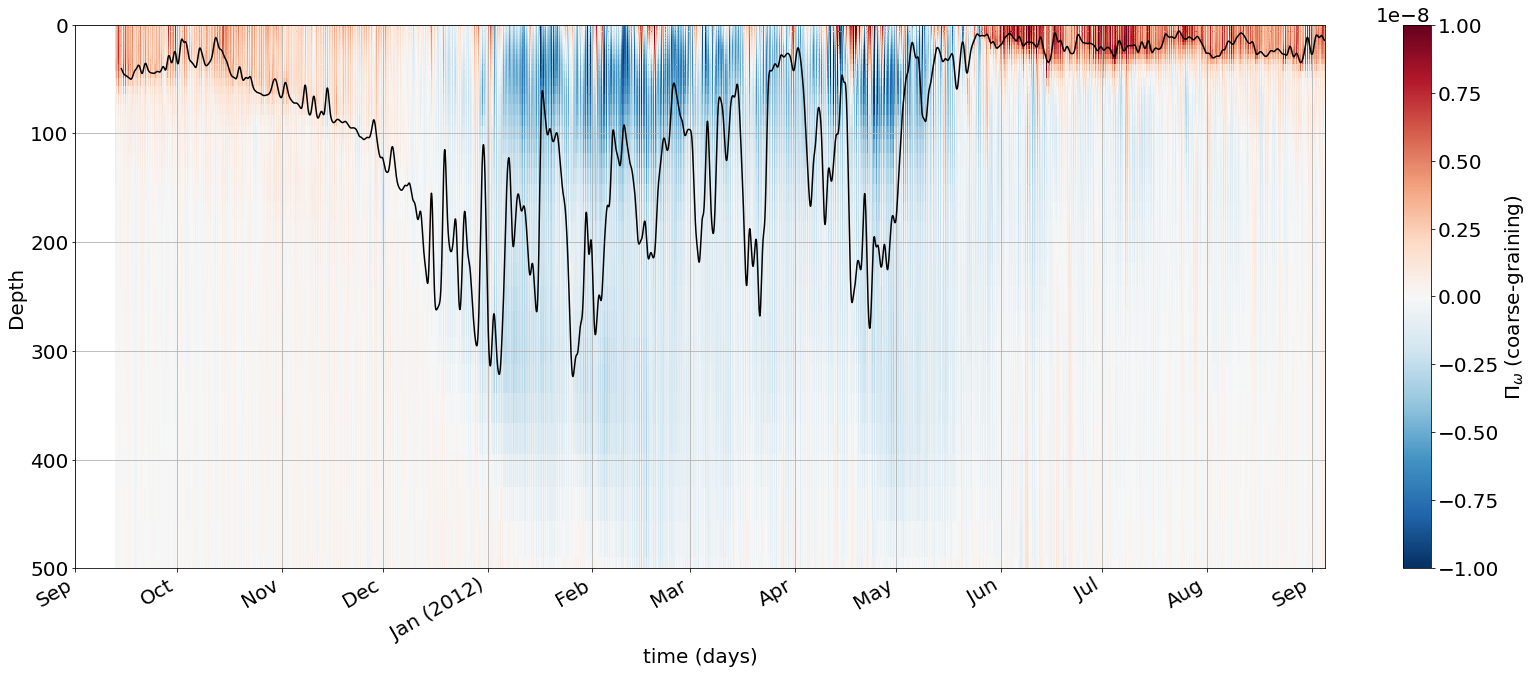

In [19]:
Pi_cg_smean = PI_cg.PI_cg_single.isel(lat=slice(13,-13),lon=slice(13,-13)).mean(['lon','lat'])

plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(28,10))

ax = plt.subplot(111)
cax = Pi_cg_smean.plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.grid()
ax.set_ylim([500., 0.])
ax.set_yticks([500,400,300,200,100,0.])
ds_MLD.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('time (days)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlim(['2011-09', '2012-09-05'])
ax.set_xticks(['2011-09','2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09'])
ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan (2012)', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])

# 2.3 KE flux $\Pi_\omega$ at 50-km scale

In [16]:
out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/'
D = [xr.open_zarr(out_dir_store+'PI_cg_50km_d%02d.zarr'%(depth)) for depth in range(51)]
PI_cg = xr.concat(D, dim='depth')

out_dir = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/'
ds_MLD = xr.open_zarr(out_dir+'mld_filter.zarr')

def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime
time_day = iters_to_date(np.arange(9415))
PI_cg = PI_cg.assign_coords(time=time_day) 
ds_MLD = xr.open_zarr(out_dir+'mld_filter.zarr')
ds_MLD = ds_MLD.assign_coords(time=time_day) 

print(PI_cg)

<xarray.Dataset>
Dimensions:       (depth: 51, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth         (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6
  * lat           (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon           (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
  * time          (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
Data variables:
    PI_cg_single  (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 1, 177), meta=np.ndarray>


Text(0.5, 1.0, 'spring')

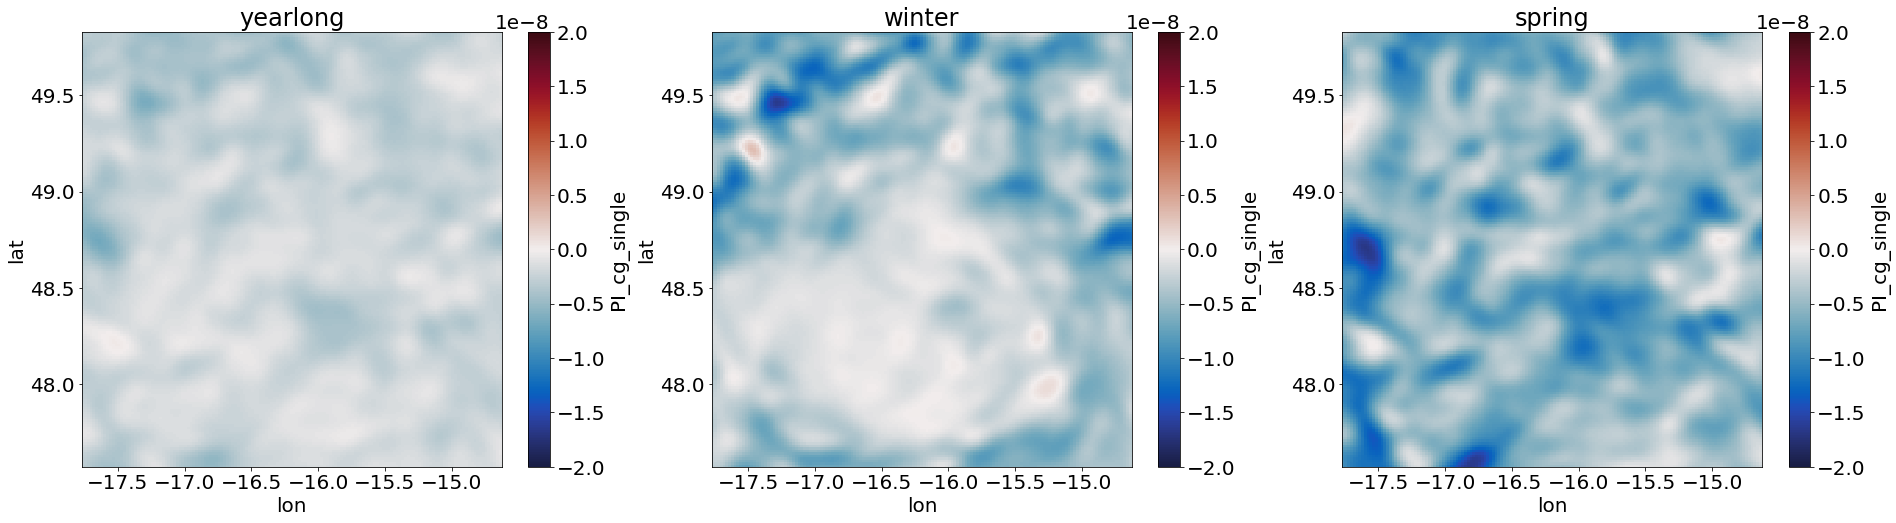

In [19]:
fig, ax = plt.subplots(figsize=(32,8))
# yearlong
ax = plt.subplot(131)
PI_cg.PI_cg_single.isel(lat=slice(13,-13),lon=slice(13,-13)).mean(['time','depth']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-2e-8,vmax=2e-8, add_colorbar = True)
ax.set_title('yearlong')
# winter
ax = plt.subplot(132)
PI_cg.PI_cg_single.isel(lat=slice(13,-13),lon=slice(13,-13)).sel(time=slice('2011-12-01T00:00:00','2012-03-01T00:00:00')).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-2e-8,vmax=2e-8, add_colorbar = True)
ax.set_title('winter')
# spring
ax = plt.subplot(133)
PI_cg.PI_cg_single.isel(lat=slice(13,-13),lon=slice(13,-13)).sel(time=slice('2012-03-01T00:00:00','2012-06-01T00:00:00')).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-2e-8,vmax=2e-8, add_colorbar = True)
ax.set_title('spring')


[Text(15218.0, 0, 'Sep'),
 Text(15248.0, 0, 'Oct'),
 Text(15279.0, 0, 'Nov'),
 Text(15309.0, 0, 'Dec'),
 Text(15340.0, 0, 'Jan (2012)'),
 Text(15371.0, 0, 'Feb'),
 Text(15400.0, 0, 'Mar'),
 Text(15431.0, 0, 'Apr'),
 Text(15461.0, 0, 'May'),
 Text(15492.0, 0, 'Jun'),
 Text(15522.0, 0, 'Jul'),
 Text(15553.0, 0, 'Aug'),
 Text(15584.0, 0, 'Sep')]

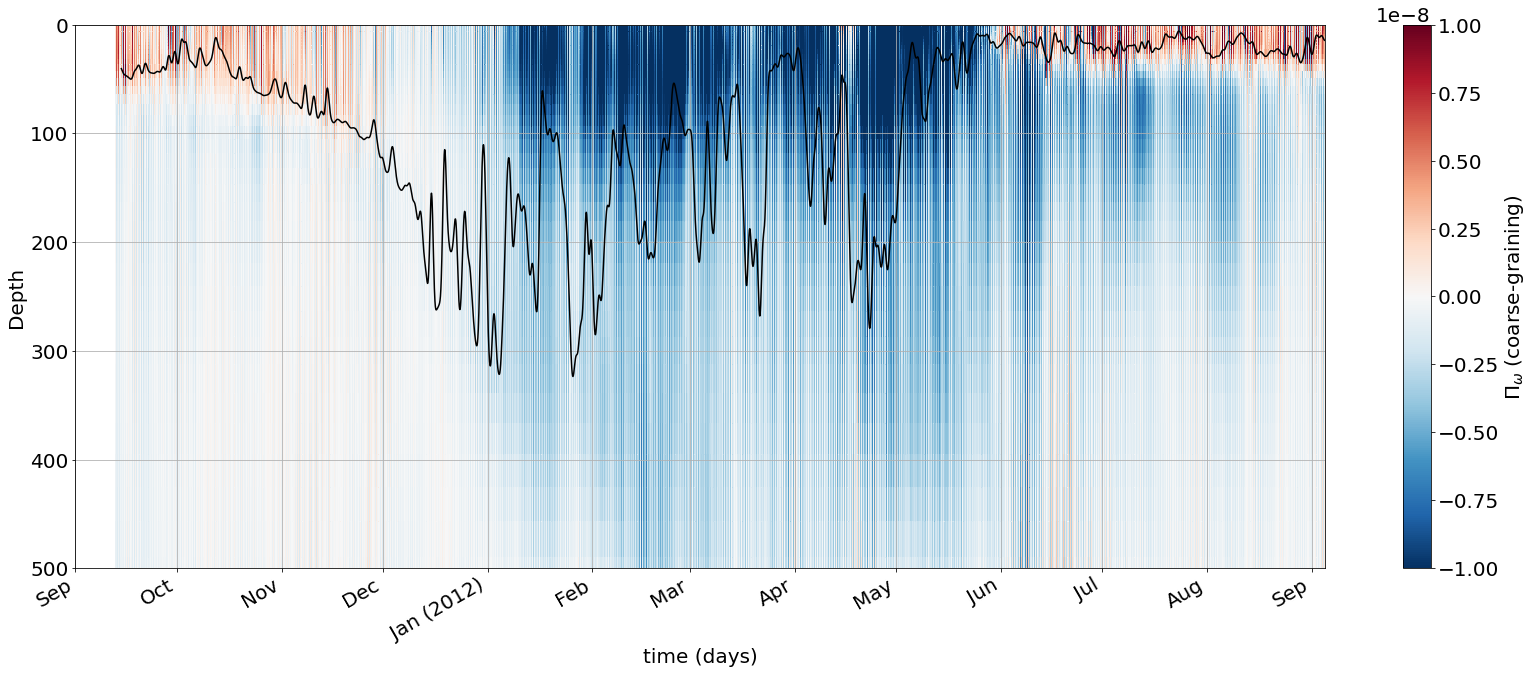

In [18]:
Pi_cg_smean = PI_cg.PI_cg_single.isel(lat=slice(13,-13),lon=slice(13,-13)).mean(['lon','lat'])

plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(28,10))

ax = plt.subplot(111)
cax = Pi_cg_smean.plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.grid()
ax.set_ylim([500., 0.])
ax.set_yticks([500,400,300,200,100,0.])
ds_MLD.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('time (days)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlim(['2011-09', '2012-09-05'])
ax.set_xticks(['2011-09','2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09'])
ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan (2012)', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])

________
# 3. Calculate $\Pi_\omega$ using the Coarse-graining method (using a temporal filter)
## KE flux $\Pi_\omega$ at 1 day, 5 days and 30 days

In [7]:
time_length = 24*1  # 1 day
time_length = 24*5  # 5 days
time_length = 24*30  # 30 days

In [8]:
wt_U = ds['U'].window
wt_U.set(n={'time': time_length}, window={'time':'hanning'},chunks = {'lat':1, 'lon_g':177,'time': 9415, 'depth':1})
ds_U_filter = wt_U.convolve()

In [9]:
wt_V = ds['V'].window
wt_V.set(n={'time': time_length}, window={'time':'hanning'},chunks = {'lat_g':1, 'lon':177,'time': 9415, 'depth':1})
ds_V_filter = wt_V.convolve()

In [10]:
wt_U2 = (ds['U']**2).window
wt_U2.set(n={'time': time_length}, window={'time':'hanning'},chunks = {'lat':1, 'lon_g':177,'time': 9415, 'depth':1})
ds_U2_filter = wt_U2.convolve()

In [11]:
wt_V2 = (ds['V']**2).window
wt_V2.set(n={'time': time_length}, window={'time':'hanning'},chunks = {'lat_g':1, 'lon':177,'time': 9415, 'depth':1})
ds_V2_filter = wt_V2.convolve()

In [12]:
uv = gridx.interp(ds.V,'Y')*gridx.interp(ds.U,'X')
wt_UV = uv.window
wt_UV.set(n={'time': time_length}, window={'time':'hanning'},chunks = {'lat':1, 'lon':177,'time': 9415, 'depth':1})
ds_UV_filter = wt_UV.convolve()

In [13]:
du_dx = gridx.diff(ds_U_filter, 'X')/gridx.interp(ds.dxG, 'Y')
dv_dy = gridx.diff(ds_V_filter, 'Y')/gridx.interp(ds.dyG, 'X')
du_dy = gridx.interp(gridx.interp(gridx.diff(ds_U_filter, 'Y')/gridx.interp(ds.dyC, 'X'), 'X'), 'Y')
dv_dx = gridx.interp(gridx.interp(gridx.diff(ds_V_filter, 'X')/gridx.interp(ds.dxC, 'Y'), 'X'), 'Y')

PI_1 = (gridx.interp(ds_U2_filter, 'X')-gridx.interp(ds_U_filter**2, 'X'))*du_dx  # [f(u^2) - f(u)^2]*f(du/dx)
PI_2 = (gridx.interp(ds_V2_filter, 'Y')-gridx.interp(ds_V_filter**2, 'Y'))*dv_dy  # [f(v^2) - f(v)^2]*f(dv/dy)
PI_3 = (ds_UV_filter - gridx.interp(ds_U_filter,'X')*gridx.interp(ds_V_filter,'Y') )*(du_dy+dv_dx) # [f(uv) - f(u)f(v)]*[f(du/dy) + f(dv/dx)]

PI_cg = -(PI_1+PI_2+PI_3)
PI_cg

,Array,Chunk
Bytes,69.67 GB,6.59 MB
Shape,"(9415, 52, 201, 177)","(9415, 1, 1, 175)"
Count,3400358 Tasks,31356 Chunks
Type,float32,numpy.ndarray


In [14]:
out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/'
depth_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]

In [ ]:
VV = ['PI_cg_1d']
VV = ['PI_cg_5d']
VV = ['PI_cg_30d']

for depth in depth_all:
    
    for vv in VV:
        
        PI_cg_single = PI_cg.isel(depth=depth)
        chunks = {'lat': 1, 'lon': 177, 'time':9415}            
        PI_cg_single = PI_cg_single.chunk(chunks)
        PI_cg_single = np.real(PI_cg_single).rename('PI_cg_single')     
        PI_cg_single = PI_cg_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        PI_cg_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

# 3.1 KE flux $\Pi_\omega$ at 1-day scale

In [33]:
out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/'
D = [xr.open_zarr(out_dir_store+'PI_cg_1d_d%02d.zarr'%(depth)) for depth in range(51)]
PI_cg = xr.concat(D, dim='depth')

def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

out_dir = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/'
ds_MLD = xr.open_zarr(out_dir+'mld_filter.zarr')

def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime
time_day = iters_to_date(np.arange(9415))
PI_cg = PI_cg.assign_coords(time=time_day) 
ds_MLD = ds_MLD.assign_coords(time=time_day) 
PI_cg

,Array,Chunk
Bytes,68.33 GB,6.67 MB
Shape,"(51, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,30804 Tasks,10251 Chunks
Type,float32,numpy.ndarray


Text(0.5, 1.0, 'spring')

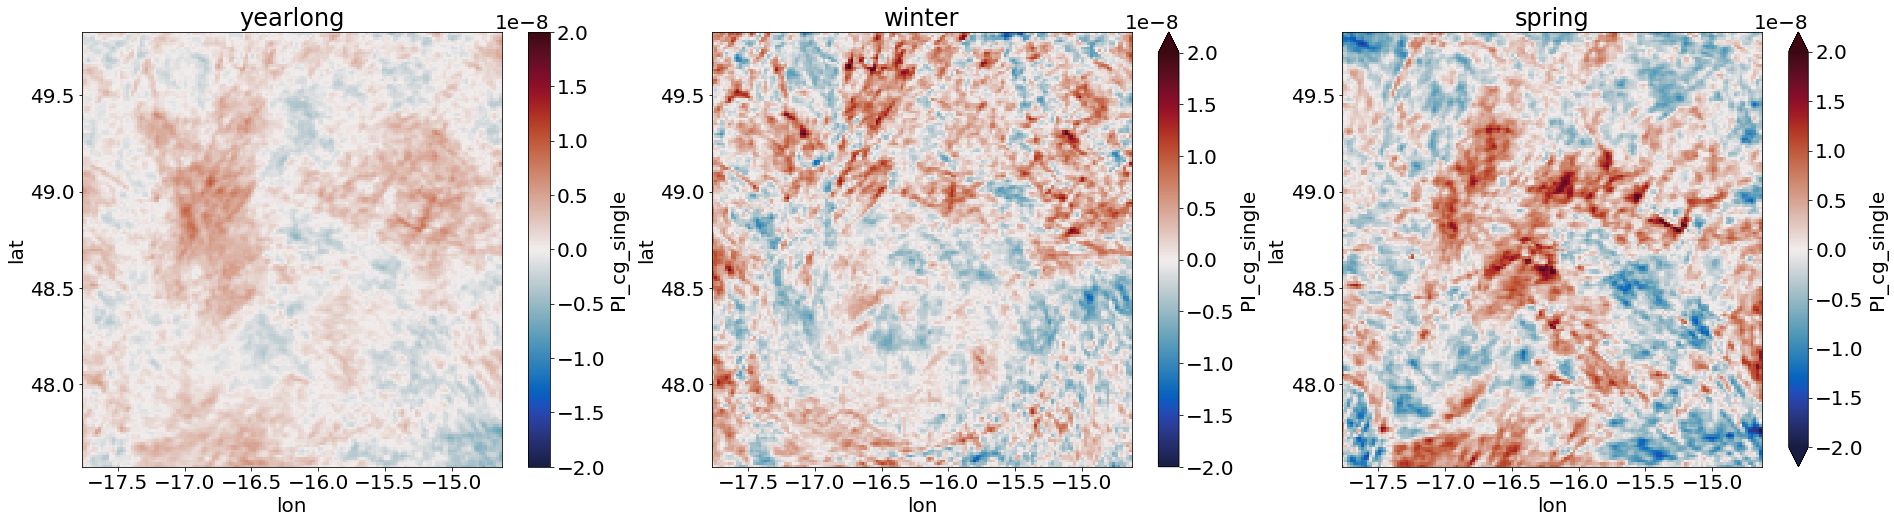

In [34]:
plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(32,8))
# yearlong
ax = plt.subplot(131)
PI_cg.PI_cg_single.isel(lat=slice(13,-13),lon=slice(13,-13)).mean(['time','depth']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-2e-8,vmax=2e-8, add_colorbar = True)
ax.set_title('yearlong')
# winter
ax = plt.subplot(132)
PI_cg.PI_cg_single.isel(lat=slice(13,-13),lon=slice(13,-13)).sel(time=slice('2011-12-01T00:00:00','2012-03-01T00:00:00')).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-2e-8,vmax=2e-8, add_colorbar = True)
ax.set_title('winter')
# spring
ax = plt.subplot(133)
PI_cg.PI_cg_single.isel(lat=slice(13,-13),lon=slice(13,-13)).sel(time=slice('2012-03-01T00:00:00','2012-06-01T00:00:00')).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-2e-8,vmax=2e-8, add_colorbar = True)
ax.set_title('spring')


[Text(15218.0, 0, 'Sep'),
 Text(15248.0, 0, 'Oct'),
 Text(15279.0, 0, 'Nov'),
 Text(15309.0, 0, 'Dec'),
 Text(15340.0, 0, 'Jan (2012)'),
 Text(15371.0, 0, 'Feb'),
 Text(15400.0, 0, 'Mar'),
 Text(15431.0, 0, 'Apr'),
 Text(15461.0, 0, 'May'),
 Text(15492.0, 0, 'Jun'),
 Text(15522.0, 0, 'Jul'),
 Text(15553.0, 0, 'Aug'),
 Text(15584.0, 0, 'Sep')]

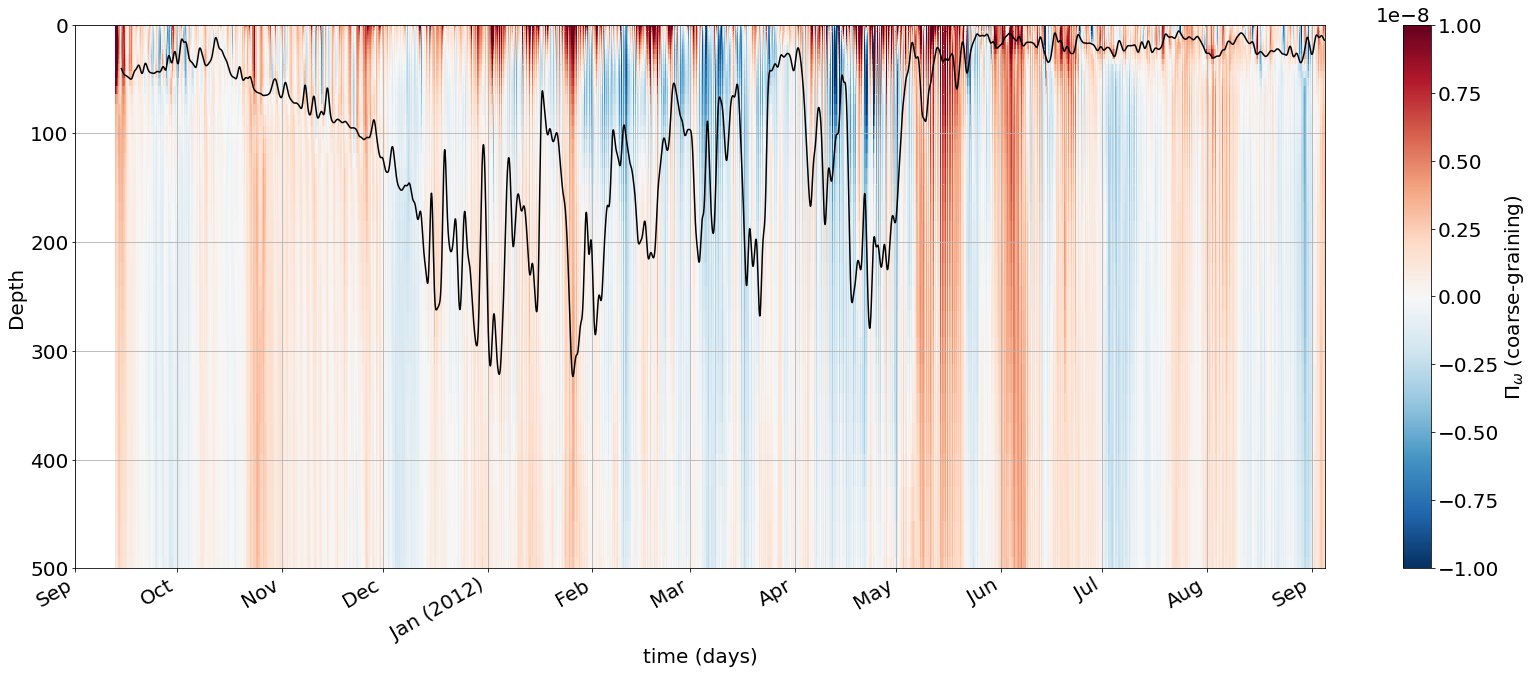

In [35]:
Pi_cg_smean = PI_cg.PI_cg_single.isel(lat=slice(13,-13),lon=slice(13,-13)).mean(['lon','lat'])

plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(28,10))

ax = plt.subplot(111)
cax = Pi_cg_smean.plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.grid()
ax.set_ylim([500., 0.])
ax.set_yticks([500,400,300,200,100,0.])
ds_MLD.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('time (days)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlim(['2011-09', '2012-09-05'])
ax.set_xticks(['2011-09','2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09'])
ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan (2012)', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])

# 3.2 KE flux $\Pi_\omega$ at 5-day scale

In [21]:
out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/'
D = [xr.open_zarr(out_dir_store+'PI_cg_5d_d%02d.zarr'%(depth)) for depth in range(51)]
PI_cg = xr.concat(D, dim='depth')

def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

out_dir = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/'
ds_MLD = xr.open_zarr(out_dir+'mld_filter.zarr')

def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime
time_day = iters_to_date(np.arange(9415))
PI_cg = PI_cg.assign_coords(time=time_day) 
ds_MLD = ds_MLD.assign_coords(time=time_day) 
PI_cg

,Array,Chunk
Bytes,68.33 GB,6.67 MB
Shape,"(51, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,30804 Tasks,10251 Chunks
Type,float32,numpy.ndarray


Text(0.5, 1.0, 'spring')

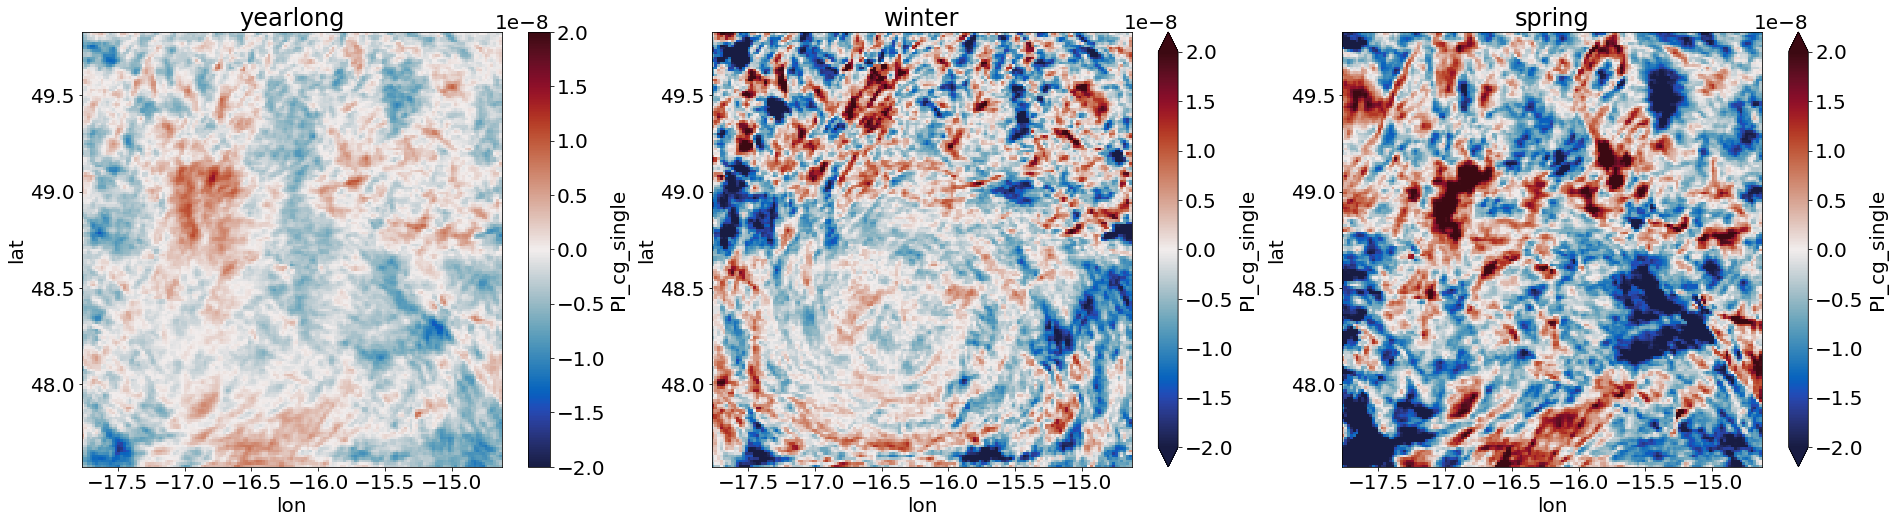

In [22]:
plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(32,8))
# yearlong
ax = plt.subplot(131)
PI_cg.PI_cg_single.isel(lat=slice(13,-13),lon=slice(13,-13)).mean(['time','depth']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-2e-8,vmax=2e-8, add_colorbar = True)
ax.set_title('yearlong')
# winter
ax = plt.subplot(132)
PI_cg.PI_cg_single.isel(lat=slice(13,-13),lon=slice(13,-13)).sel(time=slice('2011-12-01T00:00:00','2012-03-01T00:00:00')).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-2e-8,vmax=2e-8, add_colorbar = True)
ax.set_title('winter')
# spring
ax = plt.subplot(133)
PI_cg.PI_cg_single.isel(lat=slice(13,-13),lon=slice(13,-13)).sel(time=slice('2012-03-01T00:00:00','2012-06-01T00:00:00')).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-2e-8,vmax=2e-8, add_colorbar = True)
ax.set_title('spring')


[Text(15218.0, 0, 'Sep'),
 Text(15248.0, 0, 'Oct'),
 Text(15279.0, 0, 'Nov'),
 Text(15309.0, 0, 'Dec'),
 Text(15340.0, 0, 'Jan (2012)'),
 Text(15371.0, 0, 'Feb'),
 Text(15400.0, 0, 'Mar'),
 Text(15431.0, 0, 'Apr'),
 Text(15461.0, 0, 'May'),
 Text(15492.0, 0, 'Jun'),
 Text(15522.0, 0, 'Jul'),
 Text(15553.0, 0, 'Aug'),
 Text(15584.0, 0, 'Sep')]

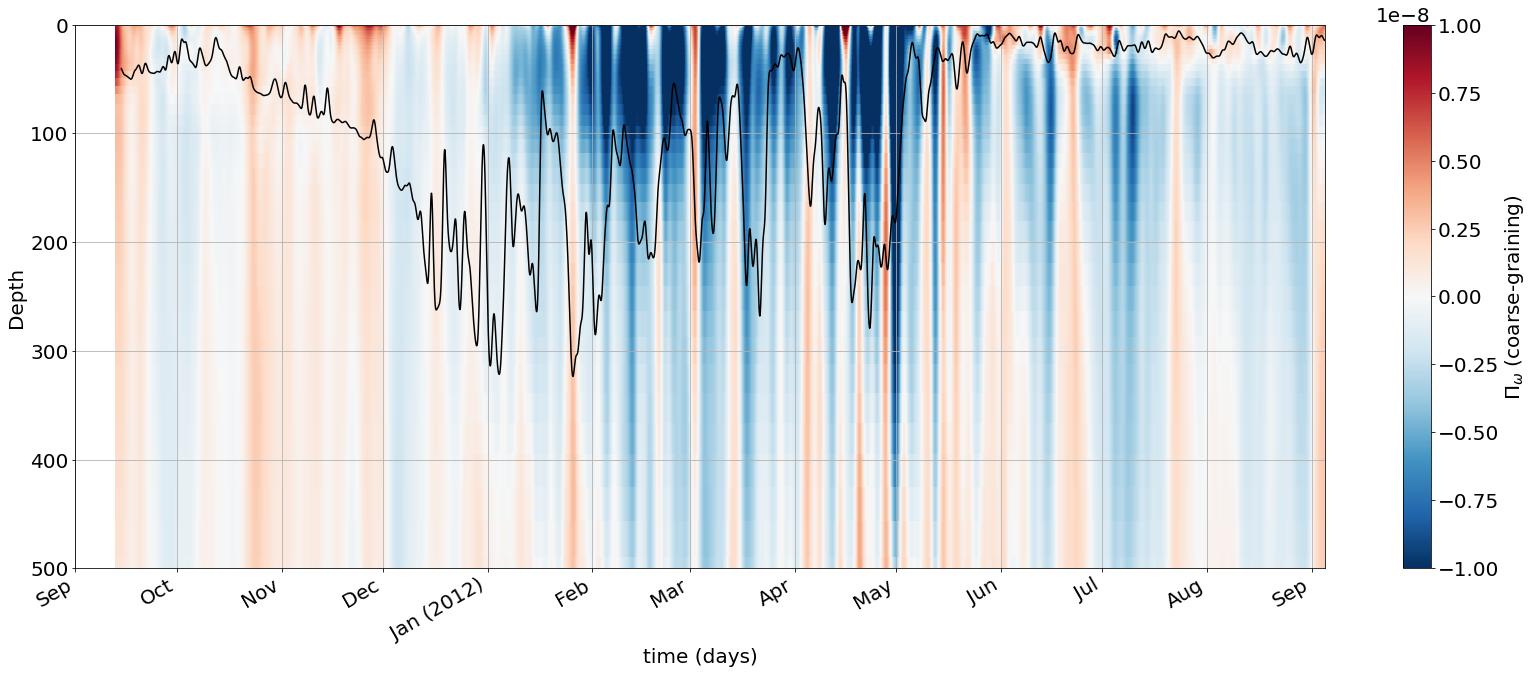

In [23]:
Pi_cg_smean = PI_cg.PI_cg_single.isel(lat=slice(13,-13),lon=slice(13,-13)).mean(['lon','lat'])

plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(28,10))

ax = plt.subplot(111)
cax = Pi_cg_smean.plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.grid()
ax.set_ylim([500., 0.])
ax.set_yticks([500,400,300,200,100,0.])
ds_MLD.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('time (days)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlim(['2011-09', '2012-09-05'])
ax.set_xticks(['2011-09','2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09'])
ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan (2012)', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])

# 3.3 KE flux $\Pi_\omega$ at 30-day scale

In [16]:
out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/'
D = [xr.open_zarr(out_dir_store+'PI_cg_30d_d%02d.zarr'%(depth)) for depth in range(51)]
PI_cg = xr.concat(D, dim='depth')

def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

out_dir = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/'
ds_MLD = xr.open_zarr(out_dir+'mld_filter.zarr')

def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime
time_day = iters_to_date(np.arange(9415))
PI_cg = PI_cg.assign_coords(time=time_day) 
ds_MLD = ds_MLD.assign_coords(time=time_day) 
PI_cg

,Array,Chunk
Bytes,68.33 GB,6.67 MB
Shape,"(51, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,30804 Tasks,10251 Chunks
Type,float32,numpy.ndarray


Text(0.5, 1.0, 'spring')

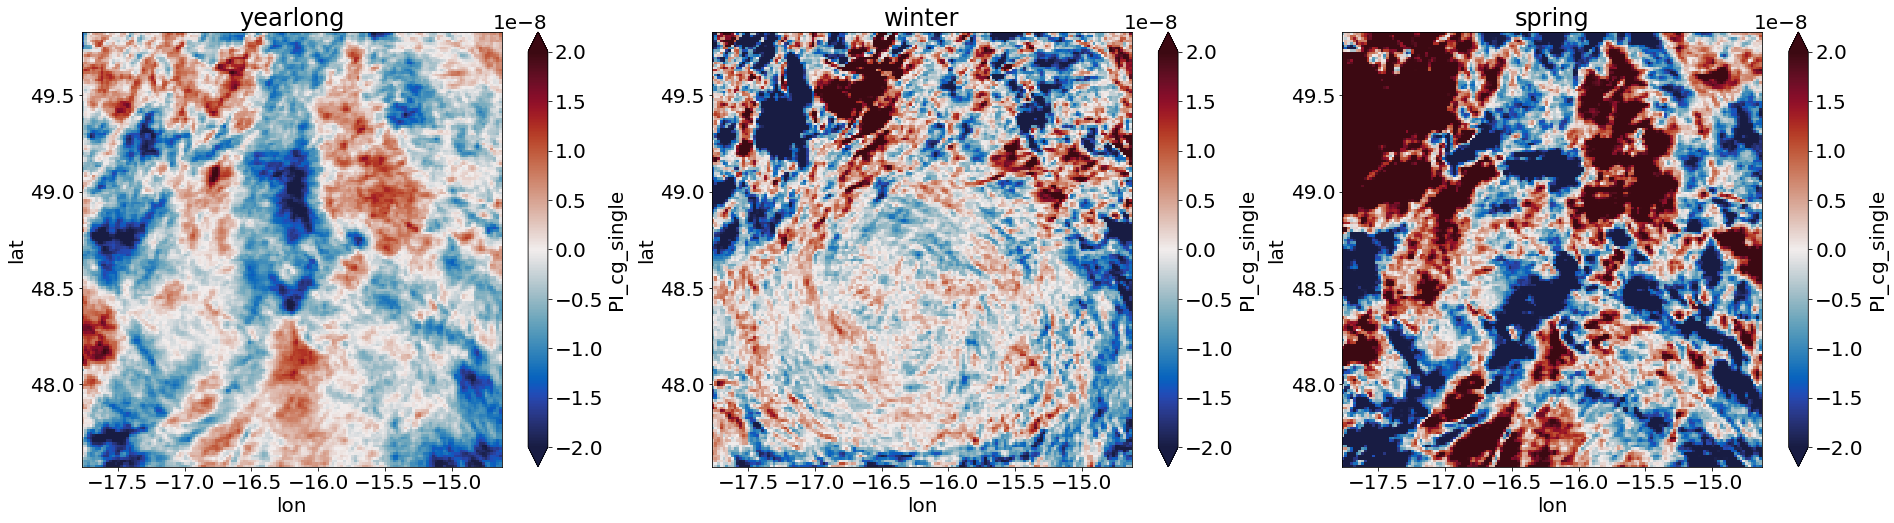

In [17]:
plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(32,8))
# yearlong
ax = plt.subplot(131)
PI_cg.PI_cg_single.isel(lat=slice(13,-13),lon=slice(13,-13)).mean(['time','depth']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-2e-8,vmax=2e-8, add_colorbar = True)
ax.set_title('yearlong')
# winter
ax = plt.subplot(132)
PI_cg.PI_cg_single.isel(lat=slice(13,-13),lon=slice(13,-13)).sel(time=slice('2011-12-01T00:00:00','2012-03-01T00:00:00')).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-2e-8,vmax=2e-8, add_colorbar = True)
ax.set_title('winter')
# spring
ax = plt.subplot(133)
PI_cg.PI_cg_single.isel(lat=slice(13,-13),lon=slice(13,-13)).sel(time=slice('2012-03-01T00:00:00','2012-06-01T00:00:00')).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-2e-8,vmax=2e-8, add_colorbar = True)
ax.set_title('spring')


[Text(15218.0, 0, 'Sep'),
 Text(15248.0, 0, 'Oct'),
 Text(15279.0, 0, 'Nov'),
 Text(15309.0, 0, 'Dec'),
 Text(15340.0, 0, 'Jan (2012)'),
 Text(15371.0, 0, 'Feb'),
 Text(15400.0, 0, 'Mar'),
 Text(15431.0, 0, 'Apr'),
 Text(15461.0, 0, 'May'),
 Text(15492.0, 0, 'Jun'),
 Text(15522.0, 0, 'Jul'),
 Text(15553.0, 0, 'Aug'),
 Text(15584.0, 0, 'Sep')]

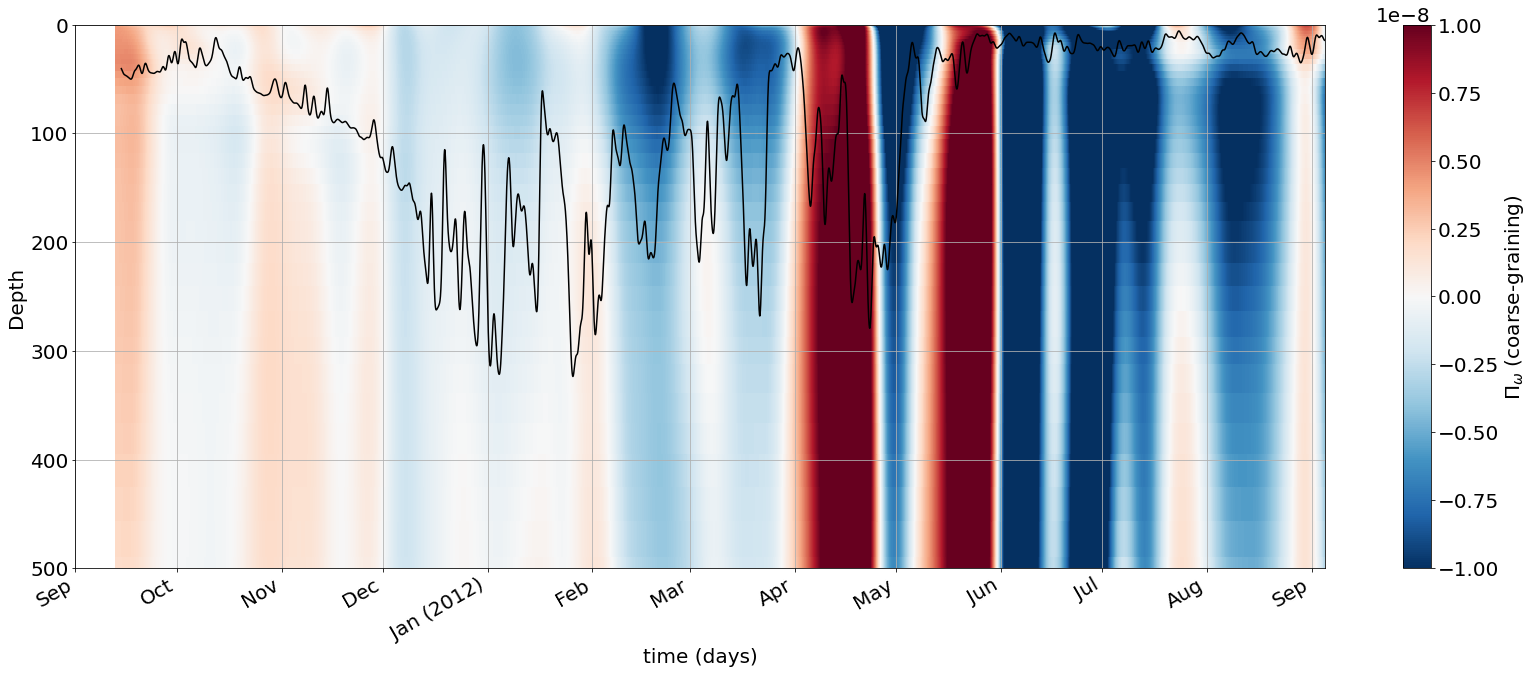

In [18]:
Pi_cg_smean = PI_cg.PI_cg_single.isel(lat=slice(13,-13),lon=slice(13,-13)).mean(['lon','lat'])

plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(28,10))

ax = plt.subplot(111)
cax = Pi_cg_smean.plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.grid()
ax.set_ylim([500., 0.])
ax.set_yticks([500,400,300,200,100,0.])
ds_MLD.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('time (days)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlim(['2011-09', '2012-09-05'])
ax.set_xticks(['2011-09','2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09'])
ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan (2012)', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])

__________
# 4. Together (spatial vs. temporal)

In [22]:
out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/'

D = [xr.open_zarr(out_dir_store+'PI_cg_1d_d%02d.zarr'%(depth)) for depth in range(51)]
PI_cg = xr.concat(D, dim='depth')
PI_cg_1d = PI_cg.PI_cg_single

D = [xr.open_zarr(out_dir_store+'PI_cg_5d_d%02d.zarr'%(depth)) for depth in range(51)]
PI_cg = xr.concat(D, dim='depth')
PI_cg_5d = PI_cg.PI_cg_single

D = [xr.open_zarr(out_dir_store+'PI_cg_30d_d%02d.zarr'%(depth)) for depth in range(51)]
PI_cg = xr.concat(D, dim='depth')
PI_cg_30d = PI_cg.PI_cg_single

D = [xr.open_zarr(out_dir_store+'PI_cg_8km_d%02d.zarr'%(depth)) for depth in range(51)]
PI_cg = xr.concat(D, dim='depth')
PI_cg_8km = PI_cg.PI_cg_single

D = [xr.open_zarr(out_dir_store+'PI_cg_20km_d%02d.zarr'%(depth)) for depth in range(51)]
PI_cg = xr.concat(D, dim='depth')
PI_cg_20km = PI_cg.PI_cg_single

D = [xr.open_zarr(out_dir_store+'PI_cg_50km_d%02d.zarr'%(depth)) for depth in range(51)]
PI_cg = xr.concat(D, dim='depth')
PI_cg_50km = PI_cg.PI_cg_single

Text(0.5, 1.0, 'yearlong')

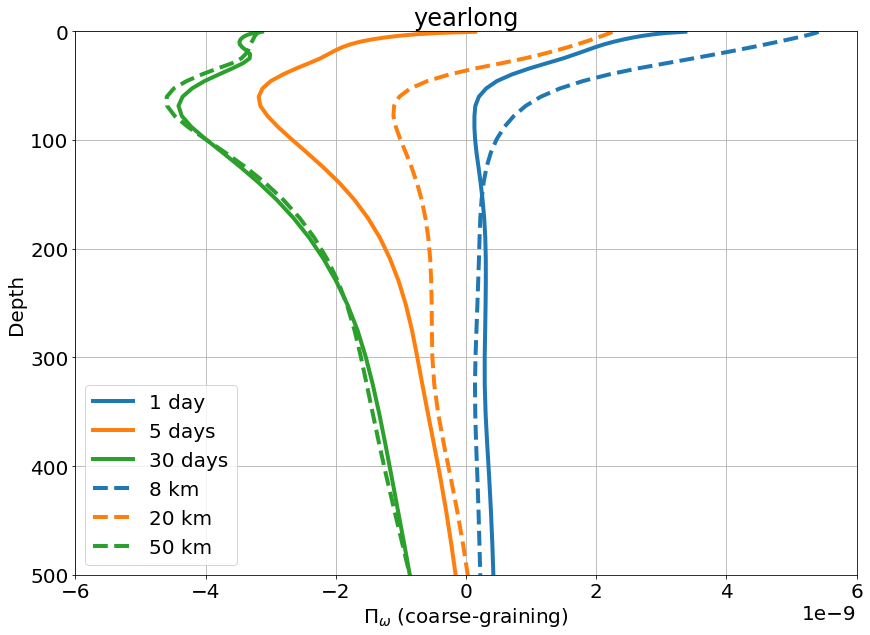

In [23]:
plt.rc('font', size=20) 
labels = ['1 day', '5 days', '30 days', '8 km', '20 km','50 km']
font_size=20

fig, ax = plt.subplots(figsize=(14,10))
ax = plt.subplot(111)
# temporal filter
PI_cg_1d.isel(lat=slice(12,-12),lon=slice(12,-12),time=slice(24,-24)).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=4, label=labels[0], color="tab:blue")
PI_cg_5d.isel(lat=slice(12,-12),lon=slice(12,-12),time=slice(24,-24)).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=4, label=labels[1], color="tab:orange")
PI_cg_30d.isel(lat=slice(12,-12),lon=slice(12,-12),time=slice(24,-24)).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=4, label=labels[2], color="tab:green")
# spatial filter
PI_cg_8km.isel(lat=slice(12,-12),lon=slice(12,-12),time=slice(24,-24)).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=4, label=labels[3], color="tab:blue", linestyle='--')
PI_cg_20km.isel(lat=slice(12,-12),lon=slice(12,-12),time=slice(24,-24)).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=4, label=labels[4], color="tab:orange", linestyle='--')
PI_cg_50km.isel(lat=slice(12,-12),lon=slice(12,-12),time=slice(24,-24)).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=4, label=labels[5], color="tab:green", linestyle='--')
ax.legend();
ax.grid()
ax.set_xlim([-6e-9,6e-9])
ax.set_ylim([500., 0.])
ax.set_xticks([-6e-9, -4e-9,-2e-9, 0, 2e-9, 4e-9, 6e-9])
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (coarse-graining)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([500,400,300,200,100,0])
ax.set_title('yearlong')

In [25]:
cluster.close()

In [25]:
def filter_2D(v, grid_num):
        
    wt = v.window    
    if "U" in v:
        wt.set(n={'lat': grid_num, 'lon_g': grid_num}, window={'lat':'hanning', 'lon_g':'hanning'}, chunks = {'lat':1, 'lon_g':177,'time': 9415, 'depth':1})
    elif "V" in v:
        wt.set(n={'lat_g': grid_num, 'lon': grid_num}, window={'lat_g':'hanning', 'lon':'hanning'}, chunks = {'lat_g':1, 'lon':177,'time': 9415, 'depth':1})
    elif "UV" in v:
        wt.set(n={'lat': grid_num, 'lon': grid_num}, window={'lat':'hanning', 'lon':'hanning'}, chunks = {'lat':1, 'lon':177,'time': 9415, 'depth':1})
    
    v_filter = wt.convolve()
    
    return v_filter   
